In [ ]:
%%capture
!git lfs install
!git clone https://huggingface.co/Cene655/Imagen-pytorch

In [2]:
%%capture
!pip install git+https://github.com/cene555/Imagen-pytorch.git
!pip install git+https://github.com/openai/CLIP.git


In [3]:
%%capture
!git clone https://github.com/xinntao/Real-ESRGAN.git

In [ ]:
cd Real-ESRGAN

In [5]:
%%capture
!pip install basicsr
# facexlib and gfpgan are for face enhancement
!pip install facexlib
!pip install gfpgan

In [6]:
%%capture
!pip install -r requirements.txt
!python setup.py develop
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

In [8]:
from PIL import Image
from IPython.display import display
import torch as th
from imagen_pytorch.model_creation import create_model_and_diffusion as create_model_and_diffusion_dalle2
from imagen_pytorch.model_creation import model_and_diffusion_defaults as model_and_diffusion_defaults_dalle2
import clip
import cv2

import glob
import os
from basicsr.archs.rrdbnet_arch import RRDBNet

from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact
from gfpgan import GFPGANer
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [ ]:
options = model_and_diffusion_defaults_dalle2()
options['use_fp16'] = False
options['diffusion_steps'] = 200
options['num_res_blocks'] = 3

model, diffusion = create_model_and_diffusion_dalle2(**options)
model.eval()
#if has_cuda:
#    model.convert_to_fp16()
model.to(device)
model.load_state_dict(th.load('/content/Imagen-pytorch/imagen-pytorch.pt'))
print('total base parameters', sum(x.numel() for x in model.parameters()))

In [ ]:
num_params = sum(param.numel() for param in model.parameters())
num_params

In [110]:
def model_fn(x_t, ts, **kwargs):
    guidance_scale = 3
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

In [111]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [112]:
def get_numpy_img(img):
    scaled = ((img + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([img.shape[2], -1, 3])
    return cv2.cvtColor(reshaped.numpy(), cv2.COLOR_BGR2RGB)

In [113]:
realesrgan_model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)

In [114]:
netscale = 4

In [115]:
upsampler = RealESRGANer(
        scale=netscale,
        model_path='/content/Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth',
        model=realesrgan_model,
        tile=0,
        tile_pad=10,
        pre_pad=0,
        half=True)

In [116]:
face_enhancer = GFPGANer(
            model_path='https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth',
            upscale=4,
            arch='clean',
            channel_multiplier=2,
            bg_upsampler=upsampler)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(options['t5_name'])

In [132]:
prompt = 'A winter'

In [133]:
text_encoding = tokenizer(
            prompt,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt")
uncond_text_encoding = tokenizer(
            '',
            max_length=128,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt")

In [134]:
out_dict = {}

out_dict["tokens"] = th.cat((text_encoding['input_ids'], uncond_text_encoding['input_ids'])).to(device)
out_dict["mask"] = th.cat((text_encoding['attention_mask'], uncond_text_encoding['attention_mask'])).to(device)

In [135]:
sample = diffusion.p_sample_loop(
        model_fn,
        (2, 3, 64, 64),
        clip_denoised=True,
        model_kwargs=out_dict,
        device='cuda',
        progress=True,
        )[:1]

  0%|          | 0/200 [00:00<?, ?it/s]

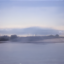

In [136]:
show_images(sample)

In [137]:
%%time
new_img = get_numpy_img(sample)
for i in range(1):
    _, _, new_img = face_enhancer.enhance(new_img, has_aligned=False, only_center_face=False, paste_back=True)

CPU times: user 80.2 ms, sys: 0 ns, total: 80.2 ms
Wall time: 81 ms


In [138]:
cv2.imwrite('/content/test_out.jpg', new_img)

True